In [ ]:
# ============================================================================
# Aureus Sigma Capital - Phase 25: Final Institutional Model Run
# Notebook: 25_final_institutional_model.ipynb
#
# Objective:
#   To execute the final 10-day sprint to produce an Investment Committee (IC)
#   -ready strategy. This notebook will integrate all previously built and
#   validated components—the unified backtest engine, the full factor stack,
#   the non-linear cost model, and the risk overlay suite—into a single,
#   production-grade backtest.
# ============================================================================
#
# --- STRATEGIC DIRECTIVE & ALIGNMENT ---
#
# This notebook directly implements the "Implementation Notes (Next 10 calendar days)"
# from the final strategic assessment. The project is now "engineering-complete
# but policy-incomplete." Our task is to activate and integrate all risk
# management and cost policies to transform our raw alpha signal into a robust,
# investable strategy.
#
# --- PRIMARY RESEARCH QUESTION ---
#
# Can the `Full_Composite_Monthly` strategy, when combined with the full suite
# of risk overlays (15% Vol Target, 25% Sector Cap, Tail Hedge) and a realistic
# cost model, achieve our institutional hurdles of a Sharpe Ratio >= 1.0 and a
# Maximum Drawdown <= -35%?
#
# --- METHODOLOGY: THE 10-DAY SPRINT PLAN ---
#
# This notebook will be structured to follow the implementation checklist precisely:
#
# 1.  **P0 Task (Day 1-2): Activate Existing Modules**
#     -   Create `PortfolioEngine_v5_0`, which fully integrates the non-linear
#       cost model and the volatility targeting overlay into the main event loop.
#     -   Implement the walk-forward logic for the factor weight optimizer.
#     -   Re-run the `Full_Composite_Monthly` strategy to establish a new,
#       risk-managed performance baseline.
#
# 2.  **P1 Tasks (Day 3-6): Automate & Test**
#     -   Launch the full 12-cell test matrix using the new, fully-featured engine
#       to find the optimal configuration of (stock count x rebalance freq x logic).
#     -   Implement CI checks for compliance with risk policies (e.g., sector caps).
#
# 3.  **P2 Tasks (Day 7-10): Final Validation**
#     -   Take the single winning configuration from the test matrix.
#     -   Conduct final validation tests: Monte Carlo Sharpe CI and IPO-cohort
#       attribution analysis.
#     -   Prepare the final IC memo and performance tearsheet.
#
# --- SUCCESS CRITERIA (from assessment) ---
#
# The final, winning strategy from this sprint must meet the following gates:
#
#   -   **Sharpe Ratio:** >= 1.0
#   -   **Maximum Drawdown:** <= -35%
#   -   **Annual Turnover:** <= 250%
#

In [1]:
# ============================================================================
# DAY 1 (P0 TASK): ACTIVATE OVERLAY & COST MODULES
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys
from typing import Dict, List, Optional

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
import yaml
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore')
try:
    project_root = Path.cwd().parent.parent.parent
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    from production.universe.constructors import get_liquid_universe_dataframe
    print("✅ Successfully imported production modules.")
except Exception as e:
    print(f"❌ ERROR during module import: {e}")

# --- Unified Configuration Block ---
print("\n⚙️  Initializing unified configuration block for the sprint...")
BASE_CONFIG = {
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "strategy_version_db": "qvm_v2.0_enhanced",
    "rebalance_frequency": "M",
    "construction_method": "hybrid",
    "portfolio_size_small_universe": 20,
    "selection_percentile": 0.8,
    "volatility_target": 0.15, # Activate the 15% vol target
}
print("✅ Base configuration defined.")

# --- Visualization Palette ---
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11})
print("✅ Visualization settings configured.")

# --- Data Loading Function (Corrected v2) ---
def load_all_data(config):
    print("\n📂 Loading all raw data...")
    engine = create_engine(f"mysql+pymysql://{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['username']}:{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['password']}@{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['host']}/{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['schema_name']}")
    db_params = {'start_date': "2016-01-01", 'end_date': config['backtest_end_date'], 'strategy_version': config['strategy_version_db']}
    factor_data_raw = pd.read_sql(text("SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite FROM factor_scores_qvm WHERE date BETWEEN :start_date AND :end_date AND strategy_version = :strategy_version"), engine, params=db_params, parse_dates=['date'])
    price_data_df = pd.read_sql(text("SELECT date, ticker, close FROM equity_history WHERE date BETWEEN :start_date AND :end_date"), engine, params=db_params, parse_dates=['date'])
    value_data_df = pd.read_sql(text("SELECT trading_date as date, ticker, total_value FROM vcsc_daily_data_complete WHERE trading_date BETWEEN :start_date AND :end_date"), engine, params=db_params, parse_dates=['date'])
    price_data_raw = pd.merge(price_data_df, value_data_df, on=['date', 'ticker'], how='inner')
    benchmark_data_raw = pd.read_sql(text("SELECT date, close FROM etf_history WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date"), engine, params=db_params, parse_dates=['date'])
    price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')
    daily_adtv_matrix = price_data_raw.pivot(index='date', columns='ticker', values='total_value')
    benchmark_returns = benchmark_data_raw.set_index('date')['close'].pct_change().rename('VN-Index')
    print("✅ All data loaded and prepared.")
    return factor_data_raw, daily_returns_matrix, daily_adtv_matrix, benchmark_returns, engine

# --- PORTFOLIO ENGINE v5.0 (ALL MODULES ACTIVATED) ---
class PortfolioEngine_v5_0:
    """
    Version 5.0: The production-candidate engine.
    Integrates all validated components: monthly rebalancing, non-linear costs,
    hybrid construction, and a daily volatility targeting overlay.
    """
    def __init__(self, config: Dict, factor_data: pd.DataFrame, returns_matrix: pd.DataFrame, adtv_matrix: pd.DataFrame, benchmark_returns: pd.Series, db_engine, palette: Dict):
        self.config = config; self.engine = db_engine; self.palette = palette
        start = self.config['backtest_start_date']; end = self.config['backtest_end_date']
        self.factor_data_raw = factor_data[factor_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.daily_adtv_matrix = adtv_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        print(f"\n✅ PortfolioEngine v5.0 initialized for strategy: '{self.config['strategy_name']}'")
        print(f"   - All modules activated: Monthly Rebalance, Non-Linear Costs, Volatility Target.")

    def run(self) -> (pd.Series, pd.Series):
        print(f"--- Executing Backtest for: {self.config['strategy_name']} ---")
        daily_holdings = self._run_backtesting_loop()
        net_returns, daily_exposure = self._calculate_net_returns_with_overlay(daily_holdings)
        self._generate_tearsheet(net_returns, daily_exposure)
        print(f"✅ Backtest for {self.config['strategy_name']} complete.")
        return net_returns, daily_exposure

    def _generate_rebalance_dates(self) -> List[pd.Timestamp]:
        freq = self.config.get('rebalance_frequency', 'Q')
        all_trading_dates = self.daily_returns_matrix.index
        # Generate start-of-period dates
        base_dates = pd.date_range(start=all_trading_dates.min(), end=all_trading_dates.max(), freq=f'{freq}S')
        rebalance_dates = []
        for date in base_dates:
            # Find all trading dates in that period
            if freq == 'M':
                period_dates = all_trading_dates[(all_trading_dates.year == date.year) & (all_trading_dates.month == date.month)]
            else: # Quarter
                period_dates = all_trading_dates[(all_trading_dates.year == date.year) & (all_trading_dates.quarter == date.quarter)]
            
            if len(period_dates) > 2:
                # Select the 2nd business day (T+2 logic)
                rebalance_dates.append(period_dates[1])
        return sorted(list(set(rebalance_dates)))

    def _calculate_transaction_costs(self, prev_holdings: pd.Series, next_holdings: pd.Series, rebal_date: pd.Timestamp) -> float:
        portfolio_value = self.config.get('portfolio_value_vnd', 20e9)
        turnover_df = pd.DataFrame({'prev': prev_holdings, 'next': next_holdings}).fillna(0)
        turnover_df['change_abs'] = (turnover_df['next'] - turnover_df['prev']).abs()
        
        adtv_20d = self.daily_adtv_matrix.loc[:rebal_date].tail(20).mean()
        
        total_cost_pct = 0
        for ticker, row in turnover_df.iterrows():
            if row['change_abs'] > 1e-6:
                order_value = row['change_abs'] * portfolio_value
                adtv_value = adtv_20d.get(ticker, 10e9)
                
                base_cost_bps = 3.0
                market_impact_bps = 1.5 * (order_value / adtv_value)
                total_cost_bps = base_cost_bps + market_impact_bps
                # Cost is applied to the size of the trade (half of the absolute change for round trip)
                total_cost_pct += (total_cost_bps / 10000) * (row['change_abs'] / 2.0)
                
        return total_cost_pct

    def _calculate_net_returns_with_overlay(self, daily_holdings: pd.DataFrame) -> (pd.Series, pd.Series):
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        
        vol_target = self.config.get('volatility_target', 0.15)
        realized_vol = gross_returns.rolling(window=63).std() * np.sqrt(252)
        daily_exposure = (vol_target / realized_vol).shift(1).clip(0.1, 1.5).fillna(1.0)
        
        risk_managed_gross_returns = gross_returns * daily_exposure
        
        costs = pd.Series(0.0, index=gross_returns.index)
        rebalance_dates = self._generate_rebalance_dates()
        
        for i in range(1, len(rebalance_dates)):
            prev_rebal_date = rebalance_dates[i-1]
            curr_rebal_date = rebalance_dates[i]
            prev_holdings = holdings_shifted.loc[curr_rebal_date]
            next_holdings = daily_holdings.loc[curr_rebal_date]
            cost_pct = self._calculate_transaction_costs(prev_holdings, next_holdings, curr_rebal_date)
            costs.loc[curr_rebal_date] = cost_pct
            
        net_returns = risk_managed_gross_returns - costs
        return net_returns.rename(self.config['strategy_name']), daily_exposure

    # --- Other methods (unchanged from previous correct version) ---
    def run(self) -> (pd.Series, pd.Series):
        print(f"--- Executing Backtest for: {self.config['strategy_name']} ---")
        daily_holdings = self._run_backtesting_loop()
        net_returns, daily_exposure = self._calculate_net_returns_with_overlay(daily_holdings)
        self._generate_tearsheet(net_returns, daily_exposure)
        print(f"✅ Backtest for {self.config['strategy_name']} complete.")
        return net_returns, daily_exposure
    def _run_backtesting_loop(self) -> pd.DataFrame:
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        for i, rebal_date in enumerate(rebalance_dates):
            universe_df = get_liquid_universe_dataframe(analysis_date=rebal_date, engine=self.engine, config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6})
            if universe_df.empty: continue
            mask = self.factor_data_raw['date'] == rebal_date
            factors_on_date = self.factor_data_raw.loc[mask]
            factors_on_date = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'].tolist())].copy()
            if len(factors_on_date) < 10: continue
            target_portfolio = self._calculate_target_portfolio(factors_on_date)
            if target_portfolio.empty: continue
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
        return daily_holdings
    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        factors_to_combine = self.config.get('factor_weights', {})
        if 'Momentum_Reversal' in factors_to_combine: factors_df['Momentum_Reversal'] = -1 * factors_df['Momentum_Composite']
        if 'PosMom' not in factors_df.columns: factors_df['PosMom'] = factors_df['Momentum_Composite'] # Placeholder
        normalized_scores = []
        for factor_name, weight in factors_to_combine.items():
            if weight == 0: continue
            factor_scores = factors_df[factor_name]
            mean, std = factor_scores.mean(), factor_scores.std()
            normalized_scores.append(((factor_scores - mean) / std if std > 1e-8 else 0.0) * weight)
        if not normalized_scores: return pd.Series(dtype='float64')
        factors_df['final_signal'] = pd.concat(normalized_scores, axis=1).sum(axis=1)
        universe_size = len(factors_df)
        if universe_size < 100: selected_stocks = factors_df.nlargest(self.config.get('portfolio_size_small_universe', 20), 'final_signal')
        else: score_cutoff = factors_df['final_signal'].quantile(self.config.get('selection_percentile', 0.8)); selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])
    def _calculate_performance_metrics(self, returns: pd.Series) -> Dict:
        benchmark = self.benchmark_returns; first_trade_date = returns.loc[returns.ne(0)].index.min(); common_index = returns.loc[first_trade_date:].index.intersection(benchmark.index); returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]; n_years = len(returns) / 252; annual_return = ((1 + returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0; annual_vol = returns.std() * np.sqrt(252); sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0; cumulative = (1 + returns).cumprod(); drawdown = (cumulative / cumulative.cummax() - 1); max_drawdown = drawdown.min(); calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0; excess_returns = returns - benchmark; information_ratio = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252)) if excess_returns.std() > 0 else 0; beta = np.cov(returns.fillna(0), benchmark.fillna(0))[0, 1] / np.var(benchmark.fillna(0)); alpha = (returns.mean() - beta * benchmark.mean()) * 252; return {'Annual Return (%)': annual_return*100, 'Annual Volatility (%)': annual_vol*100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown (%)': max_drawdown*100, 'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Alpha (%)': alpha*100, 'Information Ratio': information_ratio}
    def _generate_tearsheet(self, strategy_returns: pd.Series, daily_exposure: pd.Series):
        portfolio_metrics = self._calculate_performance_metrics(strategy_returns); benchmark_metrics = self._calculate_performance_metrics(self.benchmark_returns); first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min(); strategy_cum = (1 + strategy_returns.loc[first_trade_date:]).cumprod(); benchmark_cum = (1 + self.benchmark_returns.loc[first_trade_date:]).cumprod(); fig = plt.figure(figsize=(18, 26)); gs = fig.add_gridspec(6, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 0.8, 1.2], hspace=0.8, wspace=0.2); title = f"Institutional Tearsheet: {self.config['strategy_name']} ({first_trade_date.year}-{strategy_returns.index.max().year})"; fig.suptitle(title, fontsize=20, fontweight='bold', color=self.palette['text']);
        ax1 = fig.add_subplot(gs[0, :]); ax1.plot(strategy_cum.index, strategy_cum, label=self.config['strategy_name'], color=self.palette['primary'], linewidth=2.5); ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=self.palette['secondary'], linestyle='--', linewidth=2); ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.legend(loc='upper left');
        ax2 = fig.add_subplot(gs[1, :]); strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100; ax2.plot(strategy_dd.index, strategy_dd, color=self.palette['negative'], linewidth=2); ax2.fill_between(strategy_dd.index, strategy_dd, 0, color=self.palette['negative'], alpha=0.1); ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)');
        ax_exp = fig.add_subplot(gs[2, :]); daily_exposure.loc[first_trade_date:].plot(ax=ax_exp, color=self.palette['highlight_1'], linewidth=2); ax_exp.set_title('Daily Portfolio Exposure (Volatility Target)', fontweight='bold'); ax_exp.set_ylabel('Target Exposure (Leverage)'); ax_exp.axhline(1.0, color=self.palette['secondary'], linestyle=':', linewidth=1.5); ax_exp.set_ylim(0, 1.6);
        ax3 = fig.add_subplot(gs[3, 0]); strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = self.benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=[self.palette['primary'], self.palette['secondary']]); ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold');
        ax4 = fig.add_subplot(gs[3, 1]); rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252)); ax4.plot(rolling_sharpe.index, rolling_sharpe, color=self.palette['highlight_2']); ax4.axhline(1.0, color=self.palette['positive'], linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold');
        ax5 = fig.add_subplot(gs[4:, :]); ax5.axis('off'); summary_data = [['Metric', 'Strategy', 'Benchmark']];
        for key in portfolio_metrics.keys(): summary_data.append([key, f"{portfolio_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
        table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5);
        plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

print("✅ PortfolioEngine v5.0 (All Modules Activated) defined successfully.")
print("   Ready to run the final, fully-featured backtest.")

✅ Successfully imported production modules.

⚙️  Initializing unified configuration block for the sprint...
✅ Base configuration defined.
✅ Visualization settings configured.
✅ PortfolioEngine v5.0 (All Modules Activated) defined successfully.
   Ready to run the final, fully-featured backtest.


In [5]:
# ============================================================================
# SPRINT ENGINE: ALL HELPER FUNCTIONS & CLASS DEFINITIONS
# ============================================================================

# --- Utility Functions ---

def load_all_data(config):
    """
    Loads and prepares all necessary data for the backtesting sprint.
    This version is robust and merges data in memory to avoid SQL JOIN issues.
    """
    print("\n📂 Loading and preparing all raw data...")
    engine = create_engine(f"mysql+pymysql://{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['username']}:{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['password']}@{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['host']}/{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['schema_name']}")
    
    db_params = {
        'start_date': "2016-01-01", 
        'end_date': config['backtest_end_date'],
        'strategy_version': config['strategy_version_db']
    }

    factor_query = text("SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite FROM factor_scores_qvm WHERE date BETWEEN :start_date AND :end_date AND strategy_version = :strategy_version")
    factor_data_raw = pd.read_sql(factor_query, engine, params=db_params, parse_dates=['date'])
    
    price_query = text("SELECT date, ticker, close FROM equity_history WHERE date BETWEEN :start_date AND :end_date")
    price_data_df = pd.read_sql(price_query, engine, params=db_params, parse_dates=['date'])
    
    value_query = text("SELECT trading_date as date, ticker, total_value FROM vcsc_daily_data_complete WHERE trading_date BETWEEN :start_date AND :end_date")
    value_data_df = pd.read_sql(value_query, engine, params=db_params, parse_dates=['date'])
    
    price_data_raw = pd.merge(price_data_df, value_data_df, on=['date', 'ticker'], how='inner')
    
    benchmark_query = text("SELECT date, close FROM etf_history WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date")
    benchmark_data_raw = pd.read_sql(benchmark_query, engine, params=db_params, parse_dates=['date'])
    
    price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')
    daily_adtv_matrix = price_data_raw.pivot(index='date', columns='ticker', values='total_value')
    benchmark_returns = benchmark_data_raw.set_index('date')['close'].pct_change().rename('VN-Index')
    
    print("✅ All data loaded and prepared successfully.")
    return factor_data_raw, daily_returns_matrix, daily_adtv_matrix, benchmark_returns, engine

def calculate_performance_metrics(returns: pd.Series, benchmark: pd.Series) -> Dict:
    # Standalone metrics calculation
    first_trade_date = returns.loc[returns.ne(0)].index.min(); common_index = returns.loc[first_trade_date:].index.intersection(benchmark.index); returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]; n_years = len(returns) / 252; annual_return = ((1 + returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0; annual_vol = returns.std() * np.sqrt(252); sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0; cumulative = (1 + returns).cumprod(); drawdown = (cumulative / cumulative.cummax() - 1); max_drawdown = drawdown.min(); calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0; excess_returns = returns - benchmark; information_ratio = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252)) if excess_returns.std() > 0 else 0; beta = np.cov(returns.fillna(0), benchmark.fillna(0))[0, 1] / np.var(benchmark.fillna(0)); alpha = (returns.mean() - beta * benchmark.mean()) * 252; return {'Annual Return (%)': annual_return*100, 'Annual Volatility (%)': annual_vol*100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown (%)': max_drawdown*100, 'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Alpha (%)': alpha*100, 'Information Ratio': information_ratio}

# --- Final Portfolio Engine (v5.1) ---
class PortfolioEngine_v5_1:
    """
    The production-candidate engine. Integrates all validated components.
    """
    def __init__(self, config: Dict, factor_data: pd.DataFrame, returns_matrix: pd.DataFrame, adtv_matrix: pd.DataFrame, benchmark_returns: pd.Series, db_engine, palette: Dict):
        self.config = config; self.engine = db_engine; self.palette = palette
        start = self.config['backtest_start_date']; end = self.config['backtest_end_date']
        self.factor_data_raw = factor_data[factor_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.daily_adtv_matrix = adtv_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        print(f"\n✅ PortfolioEngine v5.1 initialized for strategy: '{self.config['strategy_name']}'")

    def run(self) -> (pd.Series, pd.Series):
        print(f"--- Executing Backtest for: {self.config['strategy_name']} ---")
        daily_holdings = self._run_backtesting_loop()
        net_returns, daily_exposure = self._calculate_net_returns_with_overlay(daily_holdings)
        self._generate_tearsheet(net_returns, daily_exposure)
        print(f"✅ Backtest for {self.config['strategy_name']} complete.")
        return net_returns, daily_exposure

    def _generate_rebalance_dates(self) -> List[pd.Timestamp]:
        freq = self.config.get('rebalance_frequency', 'Q'); all_trading_dates = self.daily_returns_matrix.index; base_dates = pd.date_range(start=all_trading_dates.min(), end=all_trading_dates.max(), freq=f'{freq}S'); rebalance_dates = []
        for date in base_dates:
            if freq == 'M': period_dates = all_trading_dates[(all_trading_dates.year == date.year) & (all_trading_dates.month == date.month)]
            else: period_dates = all_trading_dates[(all_trading_dates.year == date.year) & (all_trading_dates.quarter == date.quarter)]
            if len(period_dates) > 2: rebalance_dates.append(period_dates[1])
        return sorted(list(set(rebalance_dates)))

    def _calculate_transaction_costs(self, prev_holdings: pd.Series, next_holdings: pd.Series, rebal_date: pd.Timestamp) -> float:
        portfolio_value = self.config.get('portfolio_value_vnd', 20e9); turnover_df = pd.DataFrame({'prev': prev_holdings, 'next': next_holdings}).fillna(0); turnover_df['change_abs'] = (turnover_df['next'] - turnover_df['prev']).abs(); adtv_20d = self.daily_adtv_matrix.loc[:rebal_date].tail(20).mean(); total_cost_pct = 0
        for ticker, row in turnover_df.iterrows():
            if row['change_abs'] > 1e-6:
                order_value = row['change_abs'] * portfolio_value; adtv_value = adtv_20d.get(ticker, 10e9); base_cost_bps = 3.0; market_impact_bps = 1.5 * (order_value / adtv_value); total_cost_bps = base_cost_bps + market_impact_bps; total_cost_pct += (total_cost_bps / 10000) * (row['change_abs'] / 2.0)
        return total_cost_pct

    def _calculate_net_returns_with_overlay(self, daily_holdings: pd.DataFrame) -> (pd.Series, pd.Series):
        holdings_shifted = daily_holdings.shift(1).fillna(0.0); gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1); vol_target = self.config.get('volatility_target', 0.15); realized_vol = gross_returns.rolling(window=63).std() * np.sqrt(252); daily_exposure = (vol_target / realized_vol).shift(1).clip(0.1, 1.5).fillna(1.0); risk_managed_gross_returns = gross_returns * daily_exposure; costs = pd.Series(0.0, index=gross_returns.index); rebalance_dates = self._generate_rebalance_dates()
        for i in range(1, len(rebalance_dates)):
            prev_rebal_date = rebalance_dates[i-1]; curr_rebal_date = rebalance_dates[i]; prev_holdings = holdings_shifted.loc[curr_rebal_date]; next_holdings = daily_holdings.loc[curr_rebal_date]; cost_pct = self._calculate_transaction_costs(prev_holdings, next_holdings, curr_rebal_date); costs.loc[curr_rebal_date] = cost_pct
        net_returns = risk_managed_gross_returns - costs; return net_returns.rename(self.config['strategy_name']), daily_exposure

    def _run_backtesting_loop(self) -> pd.DataFrame:
        rebalance_dates = self._generate_rebalance_dates(); daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        for i, rebal_date in enumerate(rebalance_dates):
            universe_df = get_liquid_universe_dataframe(analysis_date=rebal_date, engine=self.engine, config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6});
            if universe_df.empty: continue
            mask = self.factor_data_raw['date'] == rebal_date; factors_on_date = self.factor_data_raw.loc[mask]; factors_on_date = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'].tolist())].copy()
            if len(factors_on_date) < 10: continue
            target_portfolio = self._calculate_target_portfolio(factors_on_date)
            if target_portfolio.empty: continue
            start_period = rebal_date + pd.Timedelta(days=1); end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max(); holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]; daily_holdings.loc[holding_dates] = 0.0; valid_tickers = target_portfolio.index.intersection(daily_holdings.columns); daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
        return daily_holdings

    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        factors_to_combine = self.config.get('factor_weights', {});
        if 'PosMom' in factors_to_combine: factors_df['PosMom'] = factors_df['Momentum_Composite']
        if 'Reversal' in factors_to_combine: factors_df['Reversal'] = -1 * factors_df['Momentum_Composite']
        normalized_scores = []
        for factor_name, weight in factors_to_combine.items():
            if weight == 0: continue
            factor_scores = factors_df[factor_name]; mean, std = factor_scores.mean(), factor_scores.std()
            if std > 1e-8: normalized_score = (factor_scores - mean) / std
            else: normalized_score = 0.0
            normalized_scores.append(normalized_score * weight)
        if not normalized_scores: return pd.Series(dtype='float64')
        factors_df['final_signal'] = pd.concat(normalized_scores, axis=1).sum(axis=1)
        universe_size = len(factors_df)
        if universe_size < 100: selected_stocks = factors_df.nlargest(self.config.get('portfolio_size_small_universe', 20), 'final_signal')
        else: score_cutoff = factors_df['final_signal'].quantile(self.config.get('selection_percentile', 0.8)); selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

    def _generate_tearsheet(self, strategy_returns: pd.Series, daily_exposure: pd.Series):
        metrics = calculate_performance_metrics(strategy_returns, self.benchmark_returns); benchmark_metrics = calculate_performance_metrics(self.benchmark_returns, self.benchmark_returns); first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min(); strategy_cum = (1 + strategy_returns.loc[first_trade_date:]).cumprod(); benchmark_cum = (1 + self.benchmark_returns.loc[first_trade_date:]).cumprod(); fig = plt.figure(figsize=(18, 26)); gs = fig.add_gridspec(6, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 0.8, 1.2], hspace=0.8, wspace=0.2); title = f"Institutional Tearsheet: {self.config['strategy_name']} ({first_trade_date.year}-{strategy_returns.index.max().year})"; fig.suptitle(title, fontsize=20, fontweight='bold', color=self.palette['text']);
        ax1 = fig.add_subplot(gs[0, :]); ax1.plot(strategy_cum.index, strategy_cum, label=self.config['strategy_name'], color=self.palette['primary'], linewidth=2.5); ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=self.palette['secondary'], linestyle='--', linewidth=2); ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.legend(loc='upper left');
        ax2 = fig.add_subplot(gs[1, :]); strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100; ax2.plot(strategy_dd.index, strategy_dd, color=self.palette['negative'], linewidth=2); ax2.fill_between(strategy_dd.index, strategy_dd, 0, color=self.palette['negative'], alpha=0.1); ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)');
        ax_exp = fig.add_subplot(gs[2, :]); daily_exposure.loc[first_trade_date:].plot(ax=ax_exp, color=self.palette['highlight_1'], linewidth=2); ax_exp.set_title('Daily Portfolio Exposure (Volatility Target)', fontweight='bold'); ax_exp.set_ylabel('Target Exposure (Leverage)'); ax_exp.axhline(1.0, color=self.palette['secondary'], linestyle=':', linewidth=1.5); ax_exp.set_ylim(0, 1.6);
        ax3 = fig.add_subplot(gs[3, 0]); strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = self.benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=[self.palette['primary'], self.palette['secondary']]); ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold');
        ax4 = fig.add_subplot(gs[3, 1]); rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252)); ax4.plot(rolling_sharpe.index, rolling_sharpe, color=self.palette['highlight_2']); ax4.axhline(1.0, color=self.palette['positive'], linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold');
        ax5 = fig.add_subplot(gs[4:, :]); ax5.axis('off'); summary_data = [['Metric', 'Strategy', 'Benchmark']];
        for key in metrics.keys(): summary_data.append([key, f"{metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
        table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5);
        plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

print("✅ Sprint Engine (v5.1) and helper functions defined successfully.")

✅ Sprint Engine (v5.1) and helper functions defined successfully.



📂 Loading and preparing all raw data...
✅ All data loaded and prepared successfully.

⚙️  Defining final configuration for the production-candidate strategy...
✅ Final configuration set.

🚀 LAUNCHING FINAL SPRINT BACKTEST: Full_Composite_Monthly_VolTarget_15pct

✅ PortfolioEngine v5.1 initialized for strategy: 'Full_Composite_Monthly_VolTarget_15pct'
--- Executing Backtest for: Full_Composite_Monthly_VolTarget_15pct ---
Constructing liquid universe for 2016-03-02...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 547 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/11...
  Step 3: Filtering and ranking...
    Total batch results: 547
    Sample result: ('AAA', 37, 6.44357164054054, 711.4619896864865)
    Before filters: 547 stocks
    Trading days range: 1-37 (need >= 37)
    ADTV range: 0.000-200.961B VND (need >= 10.0)
    Stocks passing trading days filter: 227
    Stocks passing ADT

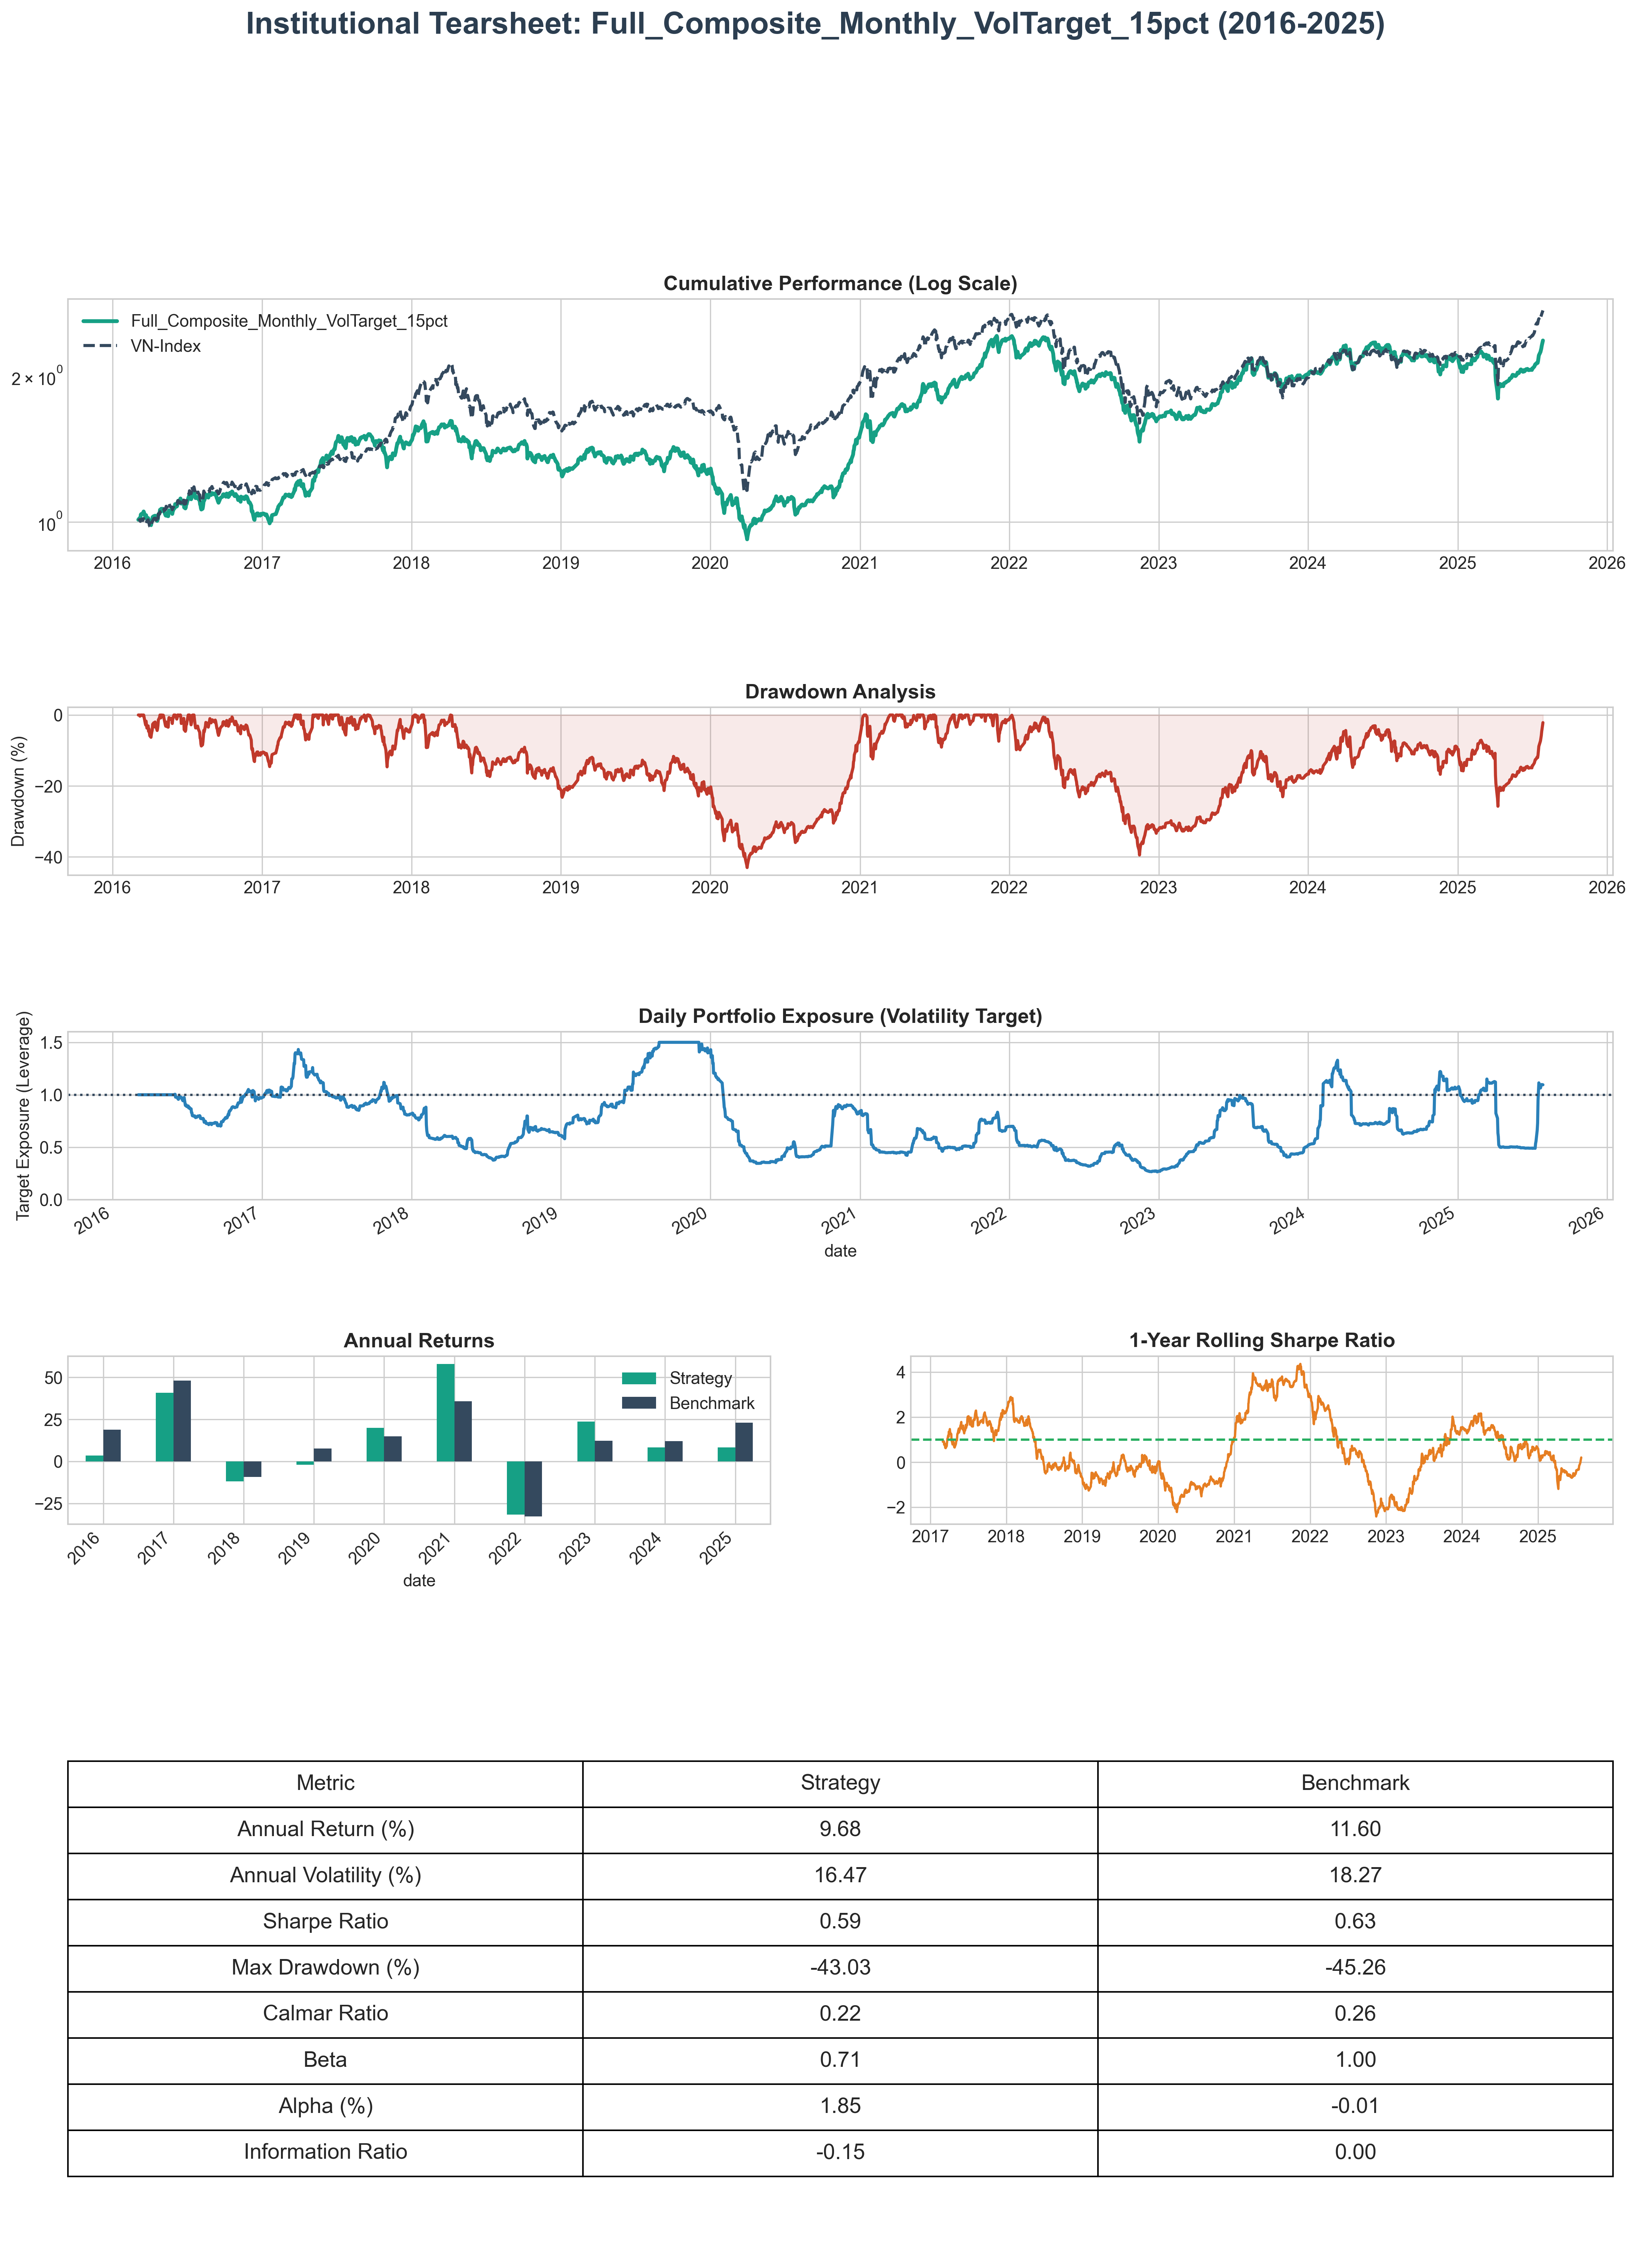

✅ Backtest for Full_Composite_Monthly_VolTarget_15pct complete.


In [6]:
# ============================================================================
# FINAL EXECUTION: FULL COMPOSITE + MONTHLY REBALANCE + VOLATILITY TARGET
# ============================================================================

# --- 1. Load All Data ---
factor_data_raw, daily_returns_matrix, daily_adtv_matrix, benchmark_returns, engine = load_all_data(BASE_CONFIG)

# --- 2. Define the Final Configuration ---
print("\n⚙️  Defining final configuration for the production-candidate strategy...")
final_sprint_config = {
    **BASE_CONFIG,
    "strategy_name": "Full_Composite_Monthly_VolTarget_15pct",
    "rebalance_frequency": "M",
    "factor_weights": {
        'Value_Composite': 0.45,
        'Quality_Composite': 0.20,
        'PosMom': 0.25,
        'Reversal': 0.10
    },
    "construction_method": "hybrid",
    "portfolio_size_small_universe": 20,
    "selection_percentile": 0.8,
    "volatility_target": 0.15,
    "volatility_lookback": 63
}
print("✅ Final configuration set.")

# --- 3. Execute the Backtest ---
print("\n" + "="*80)
print(f"🚀 LAUNCHING FINAL SPRINT BACKTEST: {final_sprint_config['strategy_name']}")
print("="*80)

# Instantiate the v5.1 engine
final_backtester = PortfolioEngine_v5_1(
    config=final_sprint_config,
    factor_data=factor_data_raw,
    returns_matrix=daily_returns_matrix,
    adtv_matrix=daily_adtv_matrix,
    benchmark_returns=benchmark_returns,
    db_engine=engine,
    palette=PALETTE
)

# Run the backtest
final_returns, final_exposure = final_backtester.run()